In [2]:
from neural_lam.datastore import init_datastore

datastore_kind = 'mdp'
config_path = '/teamspace/studios/this_studio/dk-neural-lam/era5/era.datastore.yaml'

datastore = init_datastore(
        datastore_kind=datastore_kind,
        config_path = config_path,
    )

The loaded datastore contains the following features:
 state   : wind_speed850.0hPa
 forcing : hour month
 static  : lsm
With the following splits (over time):
 train   : 2010-01-01T00:00 to 2017-06-01T00:00
 val     : 2017-07-01T00:00 to 2018-11-01T00:00
 test    : 2018-12-01T00:00 to 2019-12-31T00:00


In [3]:
datastore._ds

<xarray.Dataset> Size: 988MB
Dimensions:                         (forcing_feature: 2, time: 14605,
                                     grid_index: 3381, split_name: 3,
                                     split_part: 2, state_feature: 1,
                                     static_feature: 1)
Coordinates: (12/17)
  * forcing_feature                 (forcing_feature) <U5 40B 'hour' 'month'
    forcing_feature_long_name       (forcing_feature) <U4 32B dask.array<chunksize=(2,), meta=np.ndarray>
    forcing_feature_source_dataset  (forcing_feature) <U9 72B dask.array<chunksize=(2,), meta=np.ndarray>
    forcing_feature_units           (forcing_feature) <U1 8B dask.array<chunksize=(2,), meta=np.ndarray>
  * split_name                      (split_name) <U5 60B 'train' 'val' 'test'
  * split_part                      (split_part) <U5 40B 'start' 'end'
    ...                              ...
    static_feature_long_name        (static_feature) <U1 4B dask.array<chunksize=(1,), meta=np.ndarray>
    static_feature_source_dataset   (static_feature) <U7 28B dask.array<chunksize=(1,), meta=np.ndarray>
    static_feature_units            (static_feature) <U1 4B dask.array<chunksize=(1,), meta=np.ndarray>
  * time                            (time) datetime64[ns] 117kB 2010-01-01 .....
    x                               (grid_index) float64 27kB dask.array<chunksize=(3381,), meta=np.ndarray>
    y                               (grid_index) float64 27kB dask.array<chunksize=(3381,), meta=np.ndarray>
Dimensions without coordinates: grid_index
Data variables: (12/14)
    forcing                         (forcing_feature, time, grid_index) int64 790MB dask.array<chunksize=(2, 1, 3381), meta=np.ndarray>
    forcing__train__diff_mean       (forcing_feature) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    forcing__train__diff_std        (forcing_feature) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    forcing__train__mean            (forcing_feature) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    forcing__train__std             (forcing_feature) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    splits                          (split_name, split_part) <U16 384B dask.array<chunksize=(3, 2), meta=np.ndarray>
    ...                              ...
    state__train__diff_std          (state_feature) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    state__train__mean              (state_feature) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    state__train__std               (state_feature) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    static                          (static_feature, grid_index) float32 14kB dask.array<chunksize=(1, 3381), meta=np.ndarray>
    static__train__mean             (static_feature) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
    static__train__std              (static_feature) float32 4B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    created_on:       2025-02-10T11:42:14
    created_with:     mllam-data-prep (https://github.com/mllam/mllam-data-prep)
    dataset_version:  v0.1.0
    mdp_version:      v0.5.0
    schema_version:   v0.5.0

# Understanding datastores

In [9]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import cartopy.crs as ccrs

from IPython.display import HTML

from neural_lam.config import load_config_and_datastore


config_path = '/teamspace/studios/this_studio/dk-neural-lam/era5/config.yaml'
config, datastore = load_config_and_datastore(config_path=config_path)


def plot_example(datastore, seed: int = 0, windows: int = 7, varialbe: int = 0, frame_rate: int = 16, levels: int = 10) -> HTML:
    time_ = slice(seed, seed + windows)
    states = datastore.unstack_grid_coords(datastore._ds["state"].isel(time=time_, state_feature=varialbe))
    
    lon, lat = states.coords['x'], states.coords['y']
        
    bounds = [lon.min().item(), lon.max().item(), lat.min().item(), lat.max().item()]
    
    time_states = states.time.values

    fig, ax = plt.subplots(1, 1, figsize=(14, 7), subplot_kw={'projection': ccrs.PlateCarree()})

    vmin = states.values.min()
    vmax = states.values.max()

    fig.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.9, wspace=0.2)

    print('States:', states.shape)

    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    ax.coastlines()

    stat = ax.contourf(lon, lat, states[0].transpose('y', 'x'), levels=levels, vmin=vmin, vmax = vmax, transform=ccrs.PlateCarree())
    ax.set_title(f'Window {0} - {time_states[0]}')

    fig.colorbar(stat, ax=ax, orientation='vertical', label='Wind Speed (m/s)')

    def animate(i):
        ax.clear()
        ax.coastlines()

        ax.contourf(lon, lat, states[i].transpose('y', 'x'), levels=levels, vmin=vmin, vmax = vmax)

        ax.set_title(f'Window {i} - {time_states[i]}') # .strftime("%Y-%m-%d %H:%M:%S")
            
    frames = states.shape[0]

    interval = 1000 / frame_rate

    ani = FuncAnimation(fig, animate, frames=frames, interval=interval)

    plt.close(fig)

    return HTML(ani.to_jshtml())


plot_example(datastore, seed=1, windows=7, frame_rate=3, levels=10)

The loaded datastore contains the following features:
 state   : wind_speed850.0hPa
 forcing : hour month
 static  : lsm
With the following splits (over time):
 train   : 2010-01-01T00:00 to 2017-06-01T00:00
 val     : 2017-07-01T00:00 to 2018-11-01T00:00
 test    : 2018-12-01T00:00 to 2019-12-31T00:00
States: (7, 69, 49)


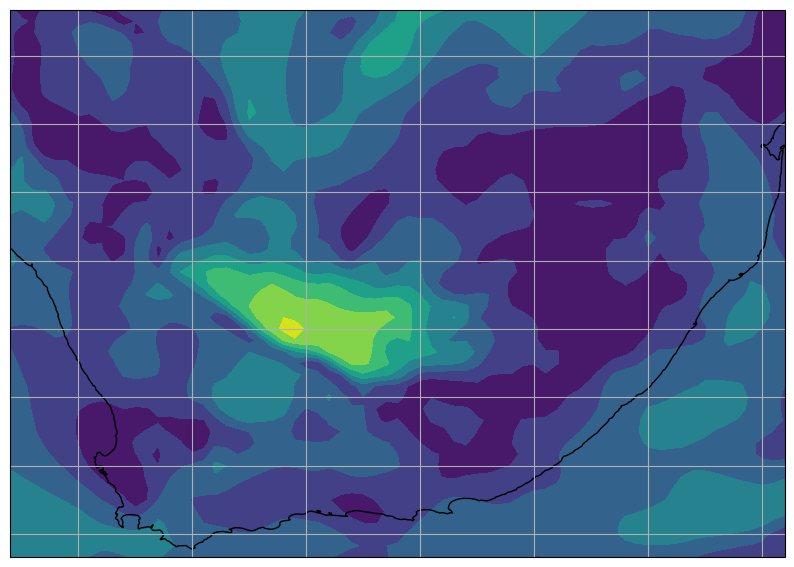

In [27]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

time_ =0
varialbe = 6

unstacked = datastore.unstack_grid_coords(datastore._ds["state"].isel(time=time_, state_feature=varialbe))

lon, lat = unstacked.coords['x'], unstacked.coords['y']
# Transpose the data array to match the shape of the coordinates
unstacked = unstacked.transpose('y', 'x')

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
ax.contourf(lon, lat, unstacked.values, transform=ccrs.PlateCarree())

plt.show()

In [1]:
from neural_lam.config import load_config_and_datastore


config_path = 'C:/Users/23603526/Documents/GitHub/neural-lam-Divan/era5_2020/test_config.yaml'
config, datastore = load_config_and_datastore(config_path=config_path)

The loaded datastore contains the following features:
 state   : z850.0hPa r850.0hPa t850.0hPa u850.0hPa v850.0hPa w850.0hPa wind_speed850.0hPa
 forcing : hour month
 static  : lsm
With the following splits (over time):
 train   : 2020-01-01T00:00 to 2020-01-01T00:00
 val     : 2020-01-01T00:00 to 2020-01-01T00:00
 test    : 2020-01-01T00:00 to 2020-12-31T00:00


c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [1]:
datastore._ds

NameError: name 'datastore' is not defined

In [3]:
import xarray as xr

ds = xr.open_dataset('output_1464x7x49x69.nc')

ds.load()

<xarray.Dataset> Size: 137MB
Dimensions:               (time: 1451, prediction_timedelta: 7, longitude: 69,
                           latitude: 49)
Coordinates:
  * time                  (time) datetime64[ns] 12kB 2020-01-01T12:00:00 ... ...
  * prediction_timedelta  (prediction_timedelta) int64 56B 0 1 2 3 4 5 6
  * latitude              (latitude) float64 392B -35.0 -34.75 ... -23.25 -23.0
  * longitude             (longitude) float64 552B 16.0 16.25 ... 32.75 33.0
Data variables:
    wind_speed            (time, prediction_timedelta, longitude, latitude) float32 137MB ...
Attributes:
    description:  Wind speed at 850 hPa predictions and targets
    units:        m/s